# Credit Score Modelling Notebook
- Author: Marcellinus Aditya Witarsah
- Date: 22 July 2024

In [1]:
# Imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Data Manipulation

import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Scorecard Modelling:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Extras:
import pickle
from scipy import stats
from typing import Tuple
from typing import Union

pd.set_option('display.max_colwidth', None)

# About the Data
Table information about the dataset from [Kaggle](https://www.kaggle.com/datasets/laotse/credit-risk-dataset).
|      **Feature Name**      |               **Description**               |
|:--------------------------:|:-------------------------------------------:|
| person_age                 | Age                                         |
| person_income              | Annual Income                               |
| person_home_ownership      | Home ownership                              |
| person_emp_length          | Employment length (in years)                |
| loan_intent                | Loan intent                                 |
| loan_grade                 | Loan grade                                  |
| loan_amnt                  | Loan amount                                 |
| loan_int_rate              | Interest rate                               |
| loan_status                | Loan status (0 is non default 1 is default) |
| loan_percent_income        | Percent income                              |
| cb_person_default_on_file  | Historical default                          |
| cb_preson_cred_hist_length | Credit history length                       |

# Data Load

In [2]:
# Load and inspect data
df = pd.read_csv("../data/raw/credit_risk_dataset.csv")
display(df.head())
display(df.info())
display(df.describe())

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


None

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


# Data Preparation
1. Data Splitting: Split the data into training and testing datasets.
2. Data Cleaning: Optionally handle missing values and anomalies in the training data, then apply the same transformations to the testing dataset. Note: WoE calculation already addresses these issues.
3. Weight of Evidence (WOE) and Information Value (IV) Calculation: Calculate the WoE and IV for each predictor variable.
4. Feature Selection: Select features based on their IV scores.
5. WoE Transformation: Transform the dataset values into WoE values using the calculated WoE mappings.

## Data Splitting

In [3]:
# Prepare arguments
df = pd.read_csv('../data/raw/credit_risk_dataset.csv')
target_variable = 'loan_status'
test_size = 0.3
random_state = 42

# Split data betweem train and text
X, y = df.drop(columns=[target_variable]), df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, shuffle=True, random_state=random_state)

print(f'Train features: {X_train.shape}, Train Target: {y_train.shape}')
print(f'Test features: {X_test.shape}, Test Target: {y_test.shape}')

Train features: (22806, 11), Train Target: (22806,)
Test features: (9775, 11), Test Target: (9775,)


## Weight of Evidence (WOE) and Information Value (IV)
1. ***Weight of Evidence*** (WoE) measures how good each grouped attributes (inside a predictor variable) in predicting the desired value of the binary response variable (binary classification). The formula for calculating WoE is 
    $$ \text{WoE} = \ln \left( \frac{\text{Proportion of Good}}{\text{Proportion of Bad}} \right) $$
    Where:
    - $ \text{Proportion of Good} $ is the proportion of customers who paid back (**Good Customers**).
    - $ \text{Proportion of Bad}\ $ is the proportion of default customers (**Bad Customers**).
    - $ \text{ln} $ denotes the natural logarithm.

    How to interpret WoE? High positive value of WoE leads to a high proportion of Good Customers while the lower the value of WoE leads to a high proportion of Bad Customers.

2. ***Information Value*** (IV) is to measure the predictive power of the feature on the value of the specified binary response variable (0 or 1). The formula for calculating the IV is
    $$ \text{WoE} = \sum (\text{Proportion of Good} - \text{Proportion of Bad}) * \text{WoE} $$
    Here is the table shows the interpretation of each IV.
    | Information Value | Predictive Power                        |
    |-------------------|-----------------------------------------|
    | < 0.02            | Useless in modelling                    |
    | 0.02 - 0.1        | Weak predictor                          |
    | 0.1 - 0.3         | Medium predictor                        |
    | 0.3 - 0.5         | Strong predictor                        |
    | > 0.5             | Suspiciously good. Check further        |
    
    How to interpret IV? High value of IV leads to high predictive power of a feature. IV can also be used for feature selection which works by leaving out features with low IV. 


In [4]:
import numpy as np
import pandas as pd
from typing import Union
from sklearn.base import BaseEstimator, TransformerMixin


class WOETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_columns: list, categorical_columns: list, bins: int):
        """
        Initialize `WOETransformer` class.

        Args:
            numerical_columns (list): list of numerical column names.
            categorical_columns (list): categorical column names from the dataset.
            bins (int): number of bins.
        """
        self.numerical_columns = numerical_columns
        self.categorical_columns = categorical_columns
        self.bins = bins
        self.woe_dict = {}
        self.woe_df = pd.DataFrame()
        self.iv_df = pd.DataFrame()

    def __generate_bins(
        self, df: pd.DataFrame, numerical_columns: list, bins: int
    ) -> pd.DataFrame:
        """
        Create bins for a numerical column, dividing it into a specified number of equal-sized bins.

        Args:
            df (pd.DataFrame): Pandas DataFrame containing the data.
            numerical_columns (str): list of numerical column names.
            bins (int): number of bins.
        Returns:
            pd.DataFrame: Pandas DataFrame with `numerical_column` values are changed to bin.
        """
        for numerical_column in numerical_columns:
            df[numerical_column] = pd.qcut(
                df[numerical_column], q=bins, duplicates="drop"
            )
        return df

    def __fill_missing_categorical(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Fill missing categorical columns inside Pandas DataFrame with `Missing`. All data must already been binned.

        Args:
            df (pd.DataFrame): Pandas DataFrame containing the data.
        Returns:
            pd.DataFrame: Pandas DataFrame with `numerical_column` values are changed to bin.
        """
        for column in df.columns:
            if df[column].isna().sum() > 0 and df[column].dtype in [
                "object",
                "category",
            ]:
                # Add category 'Missing' to replace the missing values
                df[column] = df[column].cat.add_categories("Missing")
                # Replace missing values with category 'Missing'
                df[column] = df[column].fillna(value="Missing")
        return df

    def __get_woe(self, value: Union[int, float], column_name: str) -> float:
        """
        Tranform column values into weight of evidence value.

        Args:
            value (Union[int, float]): value of the column.
            column_name (str): column name to be mapped to WOE value.

        Returns:
            float: weight of evidence value.
        """
        woe_value = None
        if isinstance(value, int) or isinstance(value, float):
            for interval, woe in self.woe_dict[column_name].items():
                if isinstance(interval, pd.Interval) and value in interval:
                    woe_value = woe
        if isinstance(value, str):
            woe_value = self.woe_dict[column_name][value]
        return woe_value

    def __interpret_information_value(self, value: float) -> str:
        """
        Interpret the strength of the information value.

        Args:
            value (float): information value.

        Returns:
            str: interpretation of the information value.
        """
        if value < 0.02:
            return "Not Predictive"
        elif 0.02 <= value and value < 0.1:
            return "Weak Predictive"
        elif 0.1 <= value and value < 0.3:
            return "Medium Predictive"
        elif 0.3 <= value and value < 0.5:
            return "Strong Predictive"
        else:
            return "Very Strong Predictive"

    def fit(
        self, X: pd.DataFrame, y: pd.Series = None
    ) -> Union[BaseEstimator, TransformerMixin]:
        """
        Perform binning, weight of evidence and information value calculation.

        Args:
            X (pd.DataFrame): Pandas DataFrame containing the data (predictor).
            y (pd.Series, optional): Pandas Series containing labels. Defaults to None.

        Returns:
            Union[BaseEstimator, TransformerMixin]: WOETransformer object
        """

        # 1. Perform binning on numerical column
        X_binned = self.__generate_bins(
            X.copy(deep=False), self.numerical_columns, self.bins
        )
        X_binned = self.__fill_missing_categorical(X_binned)

        # 2. Count the occurrences of the target inside each bin of the columns.
        crosstabs = {}
        for column in X_binned.columns:
            crosstabs[column] = pd.crosstab(X_binned[column], y, margins=True)

        # 3. Calculate weight of evidence for all columns
        for column, crosstab in crosstabs.items():
            # 3.1 Calculate WOE
            crosstab["proportion_not_default"] = crosstab[0] / crosstab[0]["All"]
            crosstab["proportion_default"] = crosstab[1] / crosstab[1]["All"]
            crosstab["WOE"] = np.log(
                crosstab["proportion_not_default"] / crosstab["proportion_default"]
            )
            temp_df = crosstab.reset_index().iloc[:-1, [0, -1]].copy()
            temp_df.columns = ["Value", "WOE"]

            self.woe_dict[column] = {
                row["Value"]: row["WOE"] for _, row in temp_df.iterrows()
            }  # for woe values mapping

            temp_df.loc[:, "Characteristic"] = column
            self.woe_df = pd.concat(
                (self.woe_df, temp_df), axis=0
            )  # for pandas DataFrame

            # 3.2 Calculate information value
            IV = np.sum(
                (crosstab["proportion_not_default"] - crosstab["proportion_default"])
                * crosstab["WOE"]
            )
            self.iv_df = pd.concat(
                (
                    self.iv_df,
                    pd.DataFrame(
                        {"Characteristic": [column], "Information Value": [IV]}
                    ),
                ),
                axis=0,
            )
            self.iv_df["Interpretation"] = self.iv_df["Information Value"].apply(
                lambda x: self.__interpret_information_value(x)
            )
            self.iv_df = self.iv_df.sort_values(by="Information Value", ascending=False)
        return self

    def transform(self, X: pd.DataFrame, y: pd.Series = None) -> pd.DataFrame:
        """
        Mapping predictor values into its weight of evidence values.

        Args:
            X (pd.DataFrame): Pandas DataFrame containing the data (predictor).
            y (pd.Series, optional): Pandas Series containing labels. Defaults to None.

        Returns:
            pd.DataFrame: Transformed predictor variable in form of weight of evidence values.
        """
        X_transformed = X.copy(deep=False)
        for column in X.columns:
            X_transformed[column] = X_transformed[column].apply(
                lambda x: self.__get_woe(x, column)
            )
            X_transformed[column] = X_transformed[column].fillna(
                self.woe_dict.get("Missing", 0)
            )
        return X_transformed

In [5]:
woe_transformer = WOETransformer(
    numerical_columns=X_train.select_dtypes('number').columns, 
    categorical_columns=X_train.select_dtypes(['object', 'category']).columns, 
    bins=5
)
woe_transformer = woe_transformer.fit(X_train, y_train)
woe_transformer

WOETransformer(bins=5,
               categorical_columns=Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object'),
               numerical_columns=Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object'))

In [6]:
# View information value
woe_transformer.iv_df

,Characteristic,Information Value,Interpretation
0,loan_grade,0.858398,Very Strong Predictive
0,loan_percent_income,0.710041,Very Strong Predictive
0,loan_int_rate,0.588036,Very Strong Predictive
0,person_income,0.463841,Strong Predictive
0,person_home_ownership,0.386431,Strong Predictive
0,cb_person_default_on_file,0.159914,Medium Predictive
0,loan_intent,0.088282,Weak Predictive
0,loan_amnt,0.076291,Weak Predictive
0,person_emp_length,0.057947,Weak Predictive
0,person_age,0.006026,Not Predictive


Exclude Characteristic with is interpret as `Not Predictive`

In [7]:
def plot_weight_of_evidence(df: pd.DataFrame, characteristic: str) -> None:
    """
    Plot the Weight of Evidence (WOE) for a specified characteristic.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data with 'Characteristic', 'Characteristic Value', and 'WOE' columns.
        characteristic (str): The characteristic for which to plot the WOE.
    Returns:
        None
    """
    plt.style.use('fivethirtyeight')
    filtered_df = df[df['Characteristic'] == characteristic]

    fig, ax = plt.subplots()

    # 1. Plot the WOE using barplot and point plot:
    sns.barplot(x='Value', y='WOE', data=filtered_df, ax=ax)
    sns.pointplot(x='Value', y='WOE', data=filtered_df, linestyles='--', color="red", markers="o", ax=ax)
    
    # 2. Add title, x-label and y-label:
    ax.set_title(f'WOE for {characteristic}', fontweight='bold')
    ax.set_xlabel(characteristic)
    ax.set_ylabel('Weight of Evidence (WOE)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    return fig

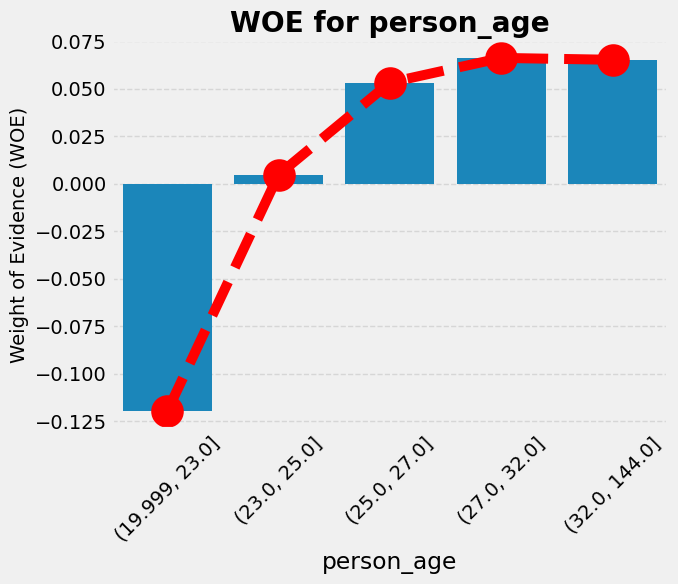

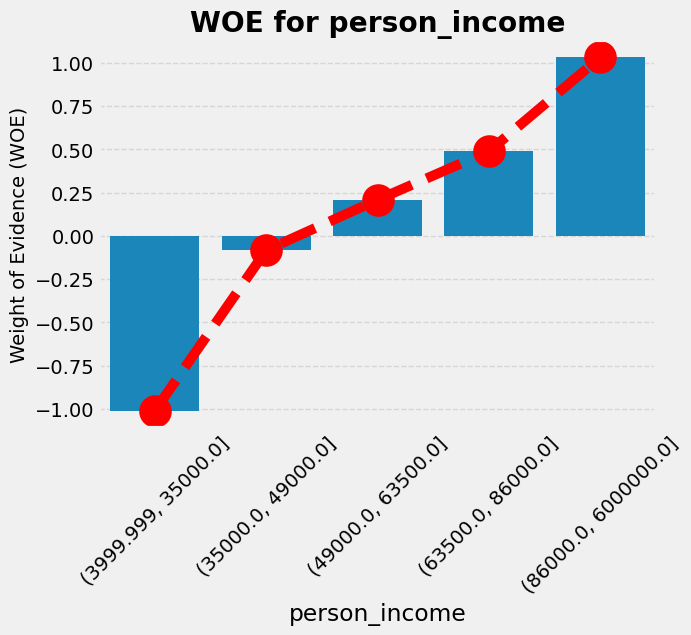

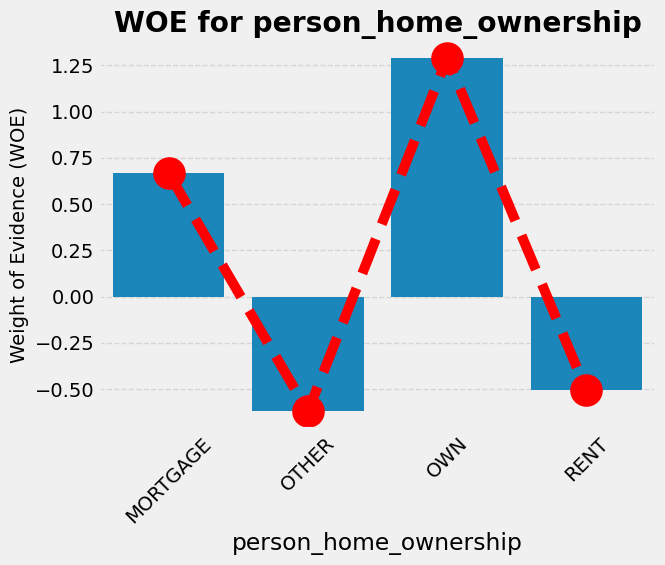

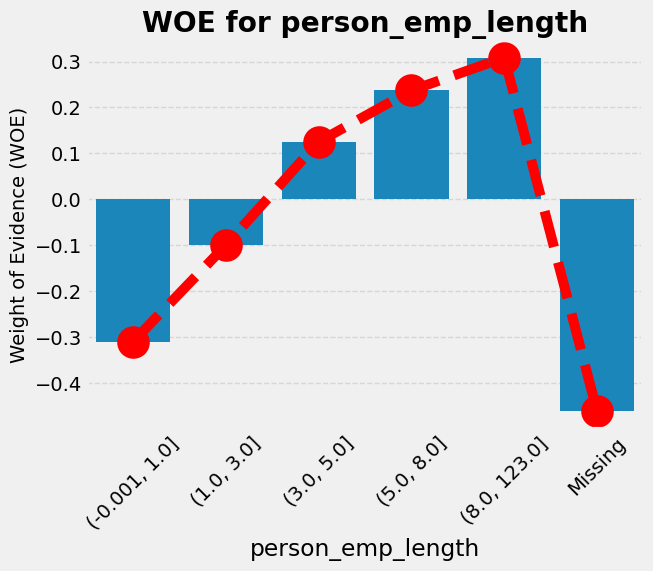

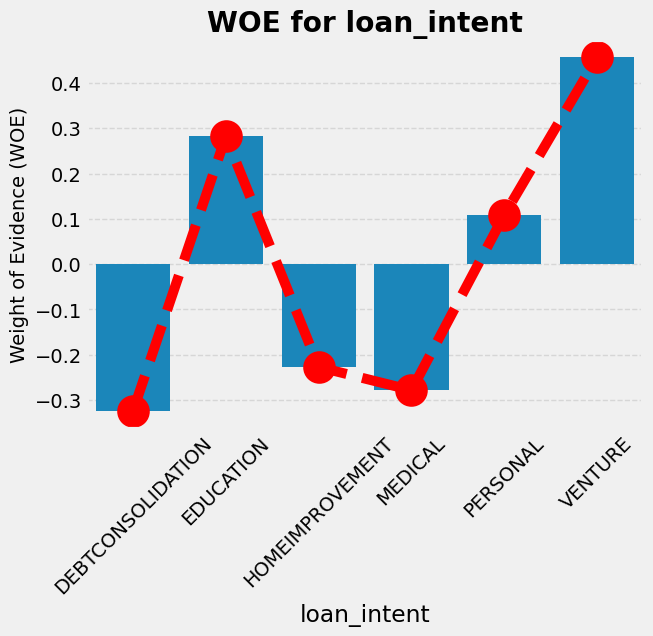

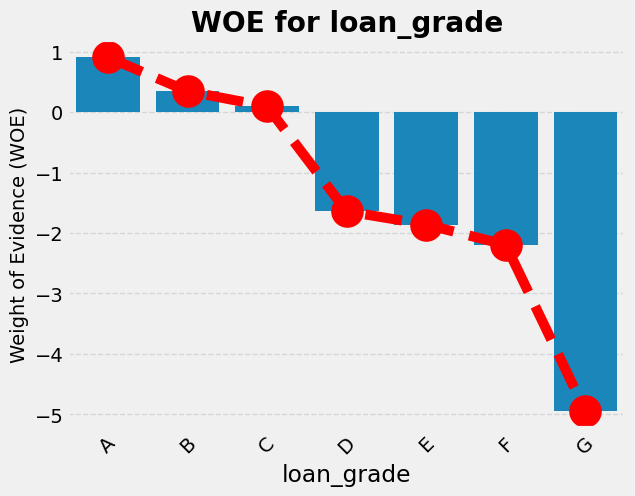

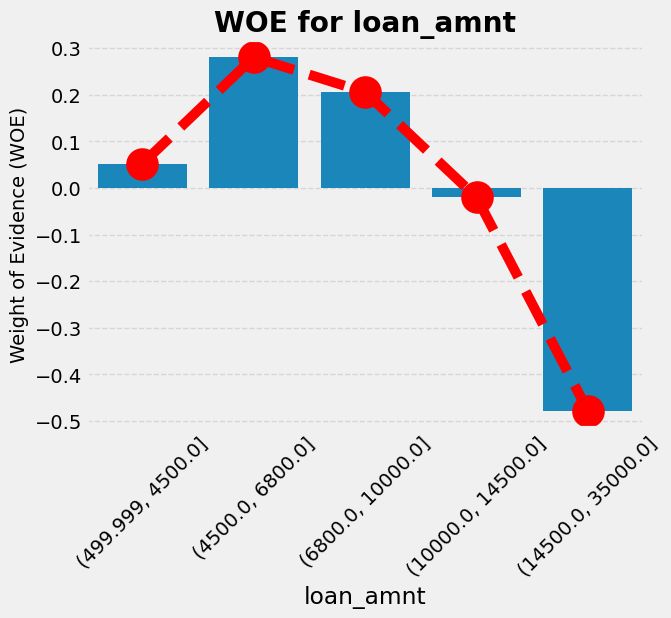

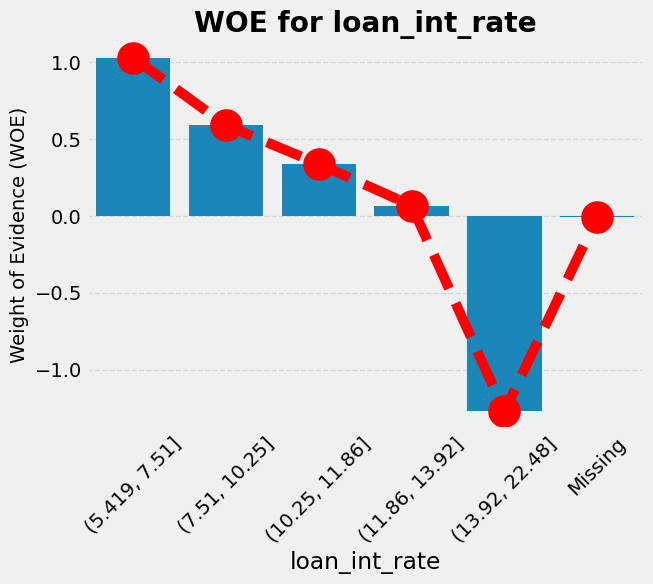

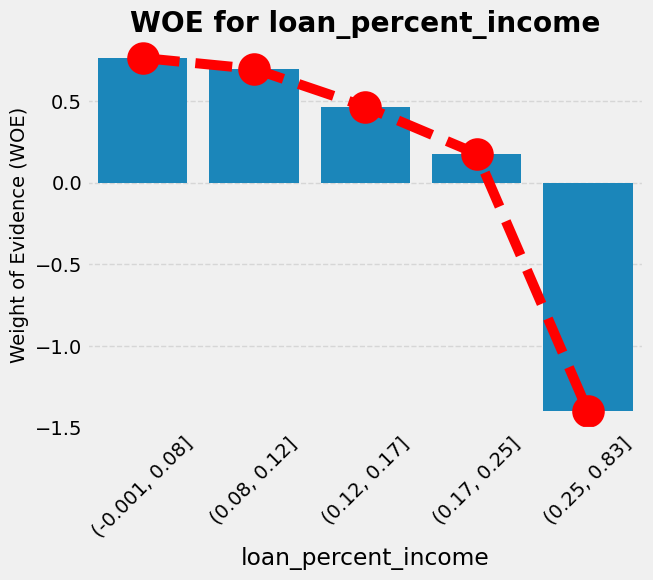

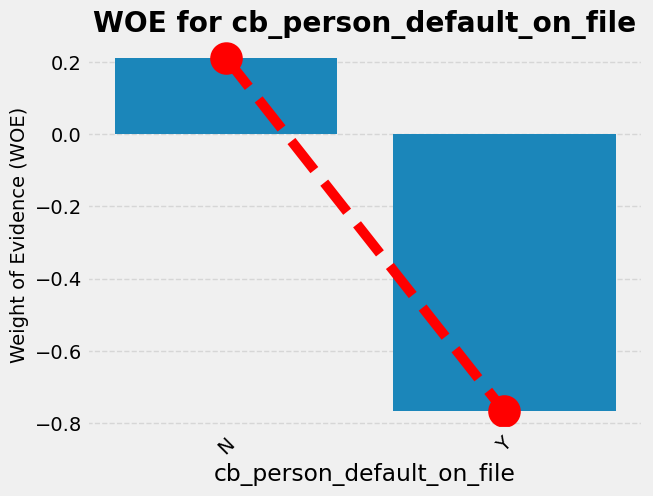

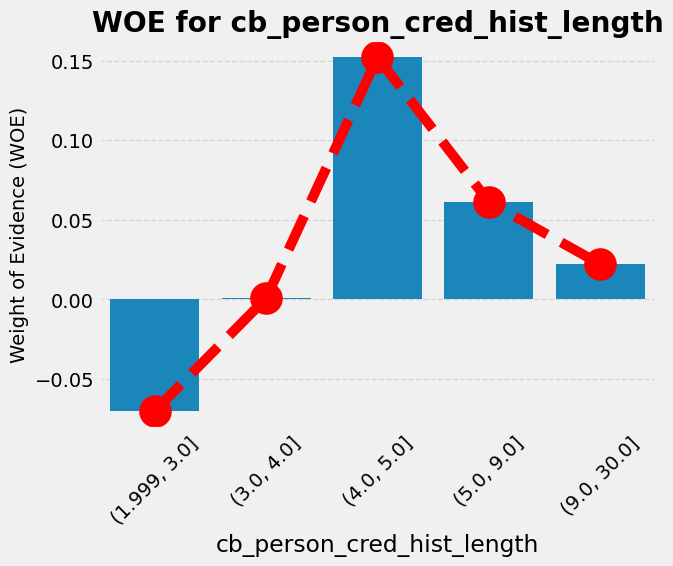

In [8]:
characteristic_names = woe_transformer.woe_df['Characteristic'].unique()
for characteristic in characteristic_names:
    plot_weight_of_evidence(woe_transformer.woe_df, characteristic)
    plt.show()

1. Those who are still producing low income has a high probability of default.
2. Those who are still new in the job has a high probability of default.
3. High interest rate (`loan_int_rate`) has a high probability of default.
4. Hihg proportion of loan with respect to income (`loan_percent_income`) has a high probability of default. 

When we plot the WoE values, we want to look for monotonicity, which means the WoE values should either gradually increase or decrease. 

### Why is Monotonicity Important?

Monotonicity indicates a consistent, predictable relationship between the predictor variable and the response variable. This is particularly important for the following reasons:

1. **Model Stability:** Monotonic relationships lead to more stable and reliable models. Non-monotonic relationships can introduce noise and reduce the model's ability to generalize well to unseen data.

2. **Interpretability:** Monotonic WoE values make the model more interpretable. It is easier to explain that as the value of a certain variable increases, the risk of default increases (or decreases), which is intuitive for stakeholders.

3. **Logistic Regression Compatibility:** Logistic regression assumes a linear relationship between the independent variables and the log-odds of the dependent variable. Monotonic WoE values help to satisfy this assumption, as they reflect a more straightforward relationship that logistic regression can capture effectively.

# Modelling
Use Logistic Regression due to its simplicity, interpretability, and transparency in prediction.

In [9]:
import time
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Union
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from credit_score_modelling.metrics import roc_auc, pr_auc, gini, ks
from credit_score_modelling.utils import logger


class WOELogisticRegression(BaseEstimator, TransformerMixin):
    def __init__(self, pipeline: Pipeline):
        """
        Initialize the WOELogisticRegression with a given pipeline.

        Args:
            pipeline (Pipeline): The scikit-learn pipeline containing the WOE transformer and Logistic Regression.
        """
        self.pipeline = pipeline

    @classmethod
    def from_file(cls, file_path: Union[str, Path]):
        """
        Create an instance of WOELogisticRegression from a saved pipeline file.

        Args:
            file_path (Union[str, Path]): Path to the file containing the saved pipeline.

        Returns:
            WOELogisticRegression: An instance of WOELogisticRegression initialized with the loaded pipeline.
        """
        with open(file_path, "rb") as file:
            pipeline = pickle.load(file)
        logger.info(
            "Load {} model from {} file".format(pipeline.__class__.__name__, file_path)
        )
        return cls(pipeline)

    @classmethod
    def from_parameters(cls, woe_transformer_params: dict, logreg_params: dict):
        """
        Create an instance of WOELogisticRegression from parameters for WOE transformer and Logistic Regression.

        Args:
            woe_transformer_params (dict): Parameters for the WOE transformer.
            logreg_params (dict): Parameters for the Logistic Regression.

        Returns:
            WOELogisticRegression: An instance of WOELogisticRegression initialized with the created pipeline.
        """
        pipeline = Pipeline(
            [
                (
                    WOETransformer.__name__,
                    WOETransformer(**woe_transformer_params),
                ),
                (LogisticRegression.__name__, LogisticRegression(**logreg_params)),
            ]
        )
        logger.info("{} model created".format(pipeline.__class__.__name__))
        return cls(pipeline)

    def fit(
        self, X: pd.DataFrame, y: pd.Series = None
    ) -> Union[BaseEstimator, TransformerMixin]:
        """
        Fit the pipeline to the training data.

        Args:
            X (pd.DataFrame): Training feature data.
            y (pd.Series, optional): Training target data. Defaults to None.

        Returns:
            Union[BaseEstimator, TransformerMixin]: The fitted WOELogisticRegression instance.
        """
        start_time = time.perf_counter()
        self.pipeline.fit(X, y)
        elapsed_time = time.perf_counter() - start_time
        logger.info(
            "{} model training finished in {:.2f} seconds.".format(
                self.pipeline.__class__.__name__, elapsed_time
            )
        )
        return self

    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Make predictions using the fitted pipeline.

        Args:
            X (pd.DataFrame): Feature data for making predictions.

        Returns:
            pd.DataFrame: Predictions made by the pipeline.
        """
        start_time = time.perf_counter()
        y_pred = self.pipeline.predict(X)
        elapsed_time = time.perf_counter() - start_time
        logger.info(
            "{} model prediction finished in {:.2f} seconds.".format(
                self.pipeline.__class__.__name__, elapsed_time
            )
        )
        return y_pred

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        """
        Predict probabilities using the fitted pipeline.

        Args:
            X (pd.DataFrame): Feature data for making probability predictions.

        Returns:
            np.ndarray: Predicted probabilities.
        """
        start_time = time.perf_counter()
        y_pred_proba = self.pipeline.predict_proba(X)
        elapsed_time = time.perf_counter() - start_time
        logger.info(
            "{} model prediction probability finished in {:.2f} seconds.".format(
                self.pipeline.__class__.__name__, elapsed_time
            )
        )
        return y_pred_proba

    def evaluate(
        self, X_test: pd.DataFrame, y_true: pd.Series, type: str = "Training"
    ) -> tuple:
        """
        Evaluate the pipeline on test data.

        Args:
            X_test (pd.DataFrame): Test feature data.
            y_true (pd.Series): True labels for the test data.
            type (str, optional): Type of evaluation ("Training" or "Validation"). Defaults to "Training".

        Returns:
            tuple: A tuple containing ROC AUC, PR AUC, GINI, and KS scores.
        """
        start_time = time.perf_counter()
        y_pred_proba = self.predict_proba(X_test)[:, 1]
        roc_auc_score = roc_auc(y_true, y_pred_proba)
        pr_auc_score = pr_auc(y_true, y_pred_proba)
        gini_score = gini(y_true, y_pred_proba)
        ks_score = ks(y_true, y_pred_proba)
        logger.info(
            "{} Performance >>> ROC AUC: {:.2f}, PR AUC: {:.2f}, GINI: {:.2f}, KS SCORE: {:.2f}".format(
                type,
                roc_auc_score,
                pr_auc_score,
                gini_score,
                ks_score,
            )
        )
        elapsed_time = time.perf_counter() - start_time
        logger.info(
            "{} model evaluation finished in {:.2f} seconds.".format(
                self.pipeline.__class__.__name__, elapsed_time
            )
        )
        return (roc_auc_score, pr_auc_score, gini_score, ks_score)

    def save(self, file: Path) -> None:
        """
        Save the pipeline to a file.

        Args:
            file (Path): Path to the file where the pipeline should be saved.
        """
        start_time = time.perf_counter()
        with open(file, "wb") as file:
            pickle.dump(self.pipeline, file)
        elapsed_time = time.perf_counter() - start_time
        logger.info(
            "Save {} model finished in {:.2f} seconds.".format(
                self.pipeline.__class__.__name__, elapsed_time
            )
        )

In [10]:
# Train
woe_transformer_params = {
    'numerical_columns': X_train.select_dtypes("number").columns,
    'categorical_columns': X_train.select_dtypes(["object", "category"] ).columns,
    'bins': 5,
}
logreg_params = {
    'random_state': 42
}
woe_logreg_model = WOELogisticRegression.from_parameters(
    woe_transformer_params = woe_transformer_params,
    logreg_params = logreg_params,
)

woe_logreg_model.fit(X_train, y_train)

2024-07-22 11:49:16,622 - credit-score-modelling-logger - INFO - Pipeline model created
2024-07-22 11:49:17,785 - credit-score-modelling-logger - INFO - Pipeline model training finished in 1.16 seconds.


WOELogisticRegression(pipeline=Pipeline(steps=[('WOETransformer',
                                                WOETransformer(bins=5,
                                                               categorical_columns=Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object'),
                                                               numerical_columns=Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object'))),
                                               ('LogisticRegression',
                                                LogisticRegression(random_state=42))]))

In [11]:
woe_transformer_params

{'numerical_columns': Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
        'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
       dtype='object'),
 'categorical_columns': Index(['person_home_ownership', 'loan_intent', 'loan_grade',
        'cb_person_default_on_file'],
       dtype='object'),
 'bins': 5}

# Model Explanation

In [12]:
intercept = woe_logreg_model.pipeline[LogisticRegression.__name__].intercept_[0]
coef = woe_logreg_model.pipeline[LogisticRegression.__name__].coef_.reshape(-1)
features = woe_logreg_model.pipeline[LogisticRegression.__name__].feature_names_in_
print("Intercept: ", intercept)
print("Coef:")
for feature, coef in zip(features, coef):
    print(f"{feature} = {coef:.5f}")

Intercept:  -1.3382882960524078
Coef:
person_age = -0.32358
person_income = -0.92974
person_home_ownership = -0.87770
person_emp_length = -0.27826
loan_intent = -1.33985
loan_grade = -1.14854
loan_amnt = -0.81561
loan_int_rate = -0.02510
loan_percent_income = -0.83871
cb_person_default_on_file = 0.04566
cb_person_cred_hist_length = -0.33327


## Explanation
Explanation of parameters inside the Logistic Regression:
1. Intercept (`intercept_`): It's the average chance of default when all other predictor variables are zero.
2. Coefficients (`coef_`): These numbers show how much each factor affects the chance of default:
    - Negative numbers mean the factor lowers the chance of default. For example, if weight of evidence person_income goes up, the chance of default goes down.
    - Positive numbers mean the factor increases the chance of default. For instance, if weight of evidence cb_person_default_on_file is 'Yes', it increases the chance of default.

Based on these coefficients if the Weight of Evidence is positively big (high percentage of non default customers) the lower the change of default because it is multiploed by the negative coefficient. Otherwise if the Weight of Evidence is massively negative (high percentage of non customers) the higher the chance of default because massive negatice values multiplied by negative coefficients result in positive log of the odds which increase the probability of default in the final prediction.

# Evaluation
Evaluation metrics that are chosen are used to assess the ***model's discriminative ability*** rather than conventional classification metrics like recall, precision, and F1-score: While recall, precision, and F1-score are useful in many classification contexts, credit risk models are often evaluated on their ability to rank-order risk and their calibration.
    
Evaluation metrics that are being chosen are:
- ***ROC AUC (Receiver Operating Characteristic Area Under the Curve)***: Measures the model's ability to distinguish between classes. It provides an aggregate measure of performance across all classification thresholds.
- ***Precision-Recall Curve***: Particularly useful in cases of imbalanced classes. It focuses on the performance related to the positive class (default cases).
- ***Gini Coefficient***: A variant of the AUC, often used in credit scoring, which ranges from 0 to 1. It measures the ability of the model to differentiate between good and bad accounts.
- ***Kolmogorov-Smirnov (KS) Statistic***: Evaluates the maximum separation between the cumulative distributions of the good and bad accounts. Higher KS values indicate better model performance.
- ***Model Calibration***: Assesses how well the predicted probabilities of default align with the actual default rates. Good calibration means that the predicted risk levels reflect true risks accurately.

In [13]:
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import calibration_curve
from credit_score_modelling.utils import logger


def plot_calibration_curve(
    y_true: np.array,
    y_pred_proba: np.array,
    model_name: str,
    path: str = None,
    n_bins=10,
) -> plt.figure:
    """
    Plot calibration curve.

    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
        model_name (str): Name of the model for labeling the plot.
        figsize (Tuple[int, int]): Size of the plot.
        path (str): Path to store plot image.
        n_bins (int): Number of bins to use for calibration curve.
    Return:
        plt.Axes: Matplotlib axis object.
    """
    start_time = time.perf_counter()
    prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=n_bins)

    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
    ax.plot(prob_pred, prob_true, marker="o", label=model_name)
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.set_title("Calibration plot")
    ax.legend()
    ax.grid(True)

    image = fig

    if path is not None:
        # Save figure
        fig.savefig(path, bbox_inches="tight")

    elapsed_time = time.perf_counter() - start_time
    logger.info(
        "Generating calibration curve plot finished in {:.2f} seconds.".format(
            elapsed_time
        )
    )
    return image


def plot_pred_proba_distribution(y_true: np.array, y_pred_proba: np.array, path: str = None) -> plt.Axes:
    """
    Plot the predicted probability distributions for the default and non-default classes.

    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
        figsize (Tuple[int, int]): size of the plot.
    Return:
        plt.Axes: Matplotlib axis object.
    """
    start_time = time.perf_counter()
    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()

    sns.histplot(
        y_pred_proba[y_true == 0],
        label="Not Default",
        kde=True,
        alpha=0.6,
        bins=30,
        ax=ax,
    )
    sns.histplot(
        y_pred_proba[y_true == 1],
        label="Default",
        kde=True,
        alpha=0.6,
        bins=30,
        ax=ax,
    )

    ax.set_title(
        "Predicted Probability Distributions for Default and Not Default",
        fontsize=16,
        fontweight="bold",
    )
    ax.set_xlabel("Predicted Probability", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.legend(title="Label", fontsize=12, title_fontsize="13")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    image = fig

    if path is not None:
        # Save figure
        fig.savefig(path, bbox_inches="tight")
        
        
    elapsed_time = time.perf_counter() - start_time
    logger.info(
        "Generating probability distributions plot finished in {:.2f} seconds.".format(
            elapsed_time
        )
    )
    return image


def plot_roc_curve(y_true: np.array, y_pred_proba: np.array, path: str = None) -> plt.Axes:
    """
    Plot the ROC curve and calculate the AUC.

    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
        figsize (Tuple[int, int]): size of the plot.
    Return:
        plt.Axes: Matplotlib axis object.
    """
    start_time = time.perf_counter()
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    ax.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")

    ax.set_title(
        "Receiver Operating Characteristic (ROC) Curve", fontsize=16, fontweight="bold"
    )
    ax.set_xlabel("False Positive Rate", fontsize=14)
    ax.set_ylabel("True Positive Rate", fontsize=14)
    ax.legend(loc="lower right", fontsize=12)
    ax.grid(axis="both", linestyle="--", alpha=0.7)

    image = fig

    if path is not None:
        # Save figure
        fig.savefig(path, bbox_inches="tight")

    elapsed_time = time.perf_counter() - start_time
    logger.info(
        "Generating ROC curve plot finished in {:.2f} seconds.".format(
            elapsed_time
        )
    )
    return image


def plot_precision_recall_curve(y_true: np.array, y_pred_proba: np.array, path: str = None) -> plt.Axes:
    """
    Plot the Precision-Recall curve and calculate the Average Precision (AP).

    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
        figsize (Tuple[int, int]): size of the plot.
    Return:
        plt.Axes: Matplotlib axis object.
    """
    start_time = time.perf_counter()
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()
    ax.plot(recall, precision, lw=2, label=f"PR curve (AP = {pr_auc:.2f})")

    ax.set_title("Precision-Recall Curve", fontsize=16, fontweight="bold")
    ax.set_xlabel("Recall", fontsize=14)
    ax.set_ylabel("Precision", fontsize=14)
    ax.legend(loc="lower left", fontsize=12)
    ax.grid(axis="both", linestyle="--", alpha=0.7)

    image = fig

    if path is not None:
        # Save figure
        fig.savefig(path, bbox_inches="tight")

    elapsed_time = time.perf_counter() - start_time
    logger.info(
        "Generating precision recall curve plot finished in {:.2f} seconds.".format(
            elapsed_time
        )
    )
    return image


def plot_ks(y_true: np.array, y_pred_proba: np.array, path: str = None) -> plt.Axes:
    """
    Plot the Kolmogorov-Smirnov (KS) statistic.

    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
        figsize (Tuple[int, int]): size of the plot.
    Return:
        plt.Axes: Matplotlib axis object.
    """
    start_time = time.perf_counter()
    y_pred_proba_not_default = y_pred_proba[y_true == 0]
    y_pred_proba_default = y_pred_proba[y_true == 1]

    ks_stat, p_value = stats.ks_2samp(y_pred_proba_not_default, y_pred_proba_default)

    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()
    ax.hist(
        y_pred_proba_not_default,
        bins=50,
        density=True,
        histtype="step",
        cumulative=True,
        label="Not Default",
        linewidth=2,
    )
    ax.hist(
        y_pred_proba_default,
        bins=50,
        density=True,
        histtype="step",
        cumulative=True,
        label="Default",
        linewidth=2,
    )
    ax.set_title("KS Plot")
    ax.set_xlabel("Value")
    ax.set_ylabel("Cumulative Probability")
    ax.legend(title=f"KS Statistic: {ks_stat:.3f}, P-value: {p_value:.3f}")

    image = fig

    if path is not None:
        # Save figure
        fig.savefig(path, bbox_inches="tight")

    elapsed_time = time.perf_counter() - start_time
    logger.info(
        "Generating ks plot finished in {:.2f} seconds.".format(
            elapsed_time
        )
    )
    return image

In [14]:
y_train_pred_proba = woe_logreg_model.predict_proba(X_train)[:, -1]

woe_logreg_model.evaluate(X_train, y_train)
woe_logreg_model.evaluate(X_test, y_test)

2024-07-22 11:49:18,991 - credit-score-modelling-logger - INFO - Pipeline model prediction probability finished in 0.68 seconds.
2024-07-22 11:49:19,663 - credit-score-modelling-logger - INFO - Pipeline model prediction probability finished in 0.67 seconds.
2024-07-22 11:49:19,681 - credit-score-modelling-logger - INFO - Training Performance >>> ROC AUC: 0.87, PR AUC: 0.71, GINI: 0.74, KS SCORE: 0.62
2024-07-22 11:49:19,682 - credit-score-modelling-logger - INFO - Pipeline model evaluation finished in 0.69 seconds.
2024-07-22 11:49:19,973 - credit-score-modelling-logger - INFO - Pipeline model prediction probability finished in 0.29 seconds.
2024-07-22 11:49:20,419 - credit-score-modelling-logger - INFO - Training Performance >>> ROC AUC: 0.87, PR AUC: 0.72, GINI: 0.74, KS SCORE: 0.61
2024-07-22 11:49:20,420 - credit-score-modelling-logger - INFO - Pipeline model evaluation finished in 0.74 seconds.


(np.float64(0.8716146967317216),
 np.float64(0.7183247007294158),
 np.float64(0.7432293934634433),
 np.float64(0.6121896745267259))

2024-07-22 11:49:21,128 - credit-score-modelling-logger - INFO - Pipeline model prediction probability finished in 0.67 seconds.
2024-07-22 11:49:21,146 - credit-score-modelling-logger - INFO - Generating calibration curve plot finished in 0.02 seconds.
2024-07-22 11:49:21,444 - credit-score-modelling-logger - INFO - Pipeline model prediction probability finished in 0.30 seconds.
2024-07-22 11:49:21,457 - credit-score-modelling-logger - INFO - Generating calibration curve plot finished in 0.01 seconds.


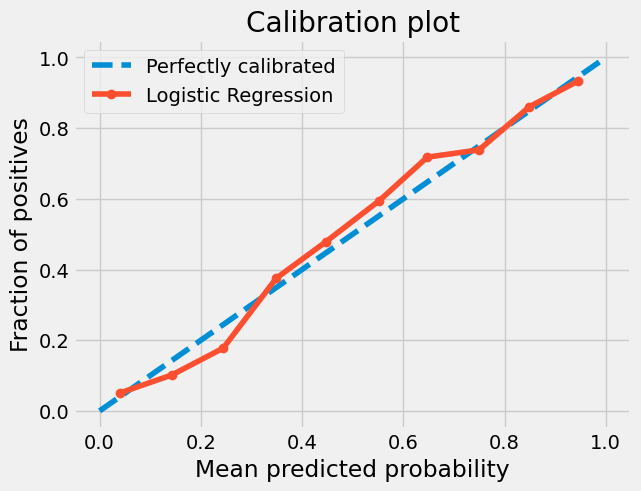

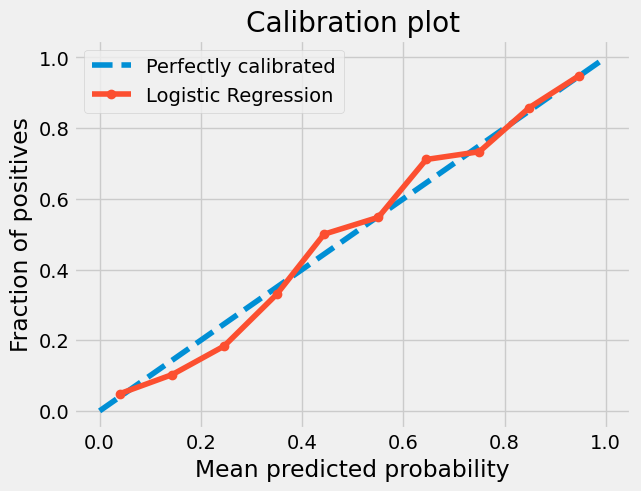

In [15]:
plot_calibration_curve(y_train, woe_logreg_model.predict_proba(X_train)[:, 1], "Logistic Regression")
plot_calibration_curve(y_test, woe_logreg_model.predict_proba(X_test)[:, 1], "Logistic Regression")
plt.show()

2024-07-22 11:49:22,373 - credit-score-modelling-logger - INFO - Pipeline model prediction probability finished in 0.66 seconds.
2024-07-22 11:49:22,603 - credit-score-modelling-logger - INFO - Generating probability distributions plot finished in 0.23 seconds.
2024-07-22 11:49:22,619 - credit-score-modelling-logger - INFO - Generating ROC curve plot finished in 0.01 seconds.
2024-07-22 11:49:22,640 - credit-score-modelling-logger - INFO - Generating precision recall curve plot finished in 0.02 seconds.
2024-07-22 11:49:22,740 - credit-score-modelling-logger - INFO - Generating ks plot finished in 0.10 seconds.


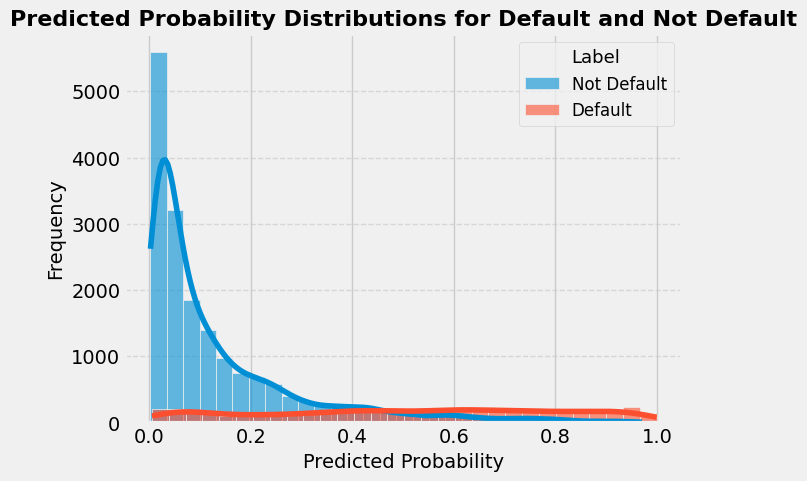

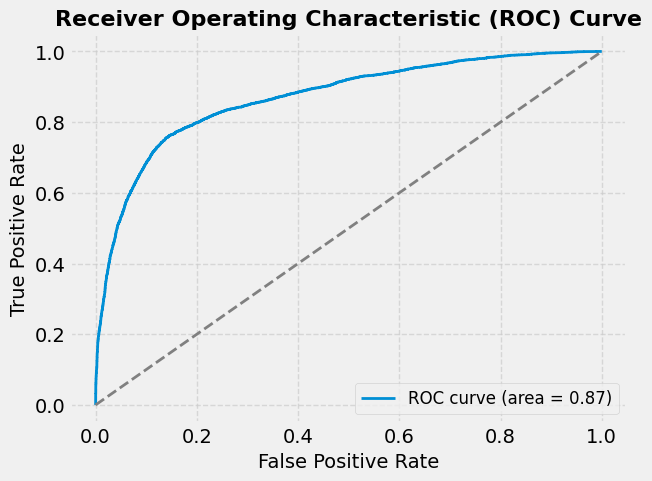

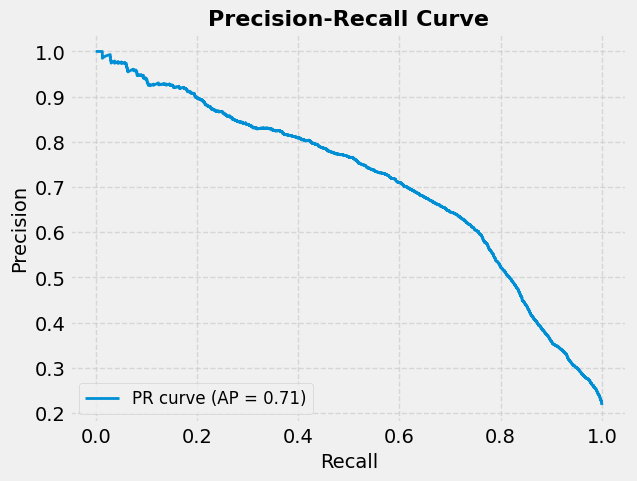

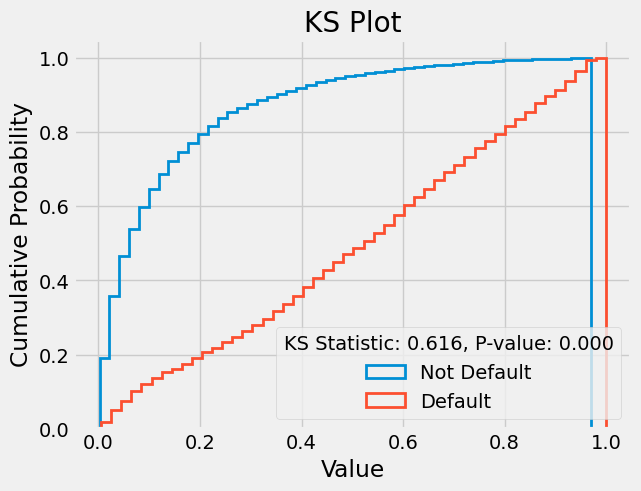

In [16]:
y_pred_proba = woe_logreg_model.predict_proba(X_train)[:, -1]
plot_pred_proba_distribution(y_train, y_pred_proba)
plot_roc_curve(y_train, y_pred_proba)
plot_precision_recall_curve(y_train, y_pred_proba)
plot_ks(y_train, y_pred_proba)
plt.show()

## Explanation
- From the evaluation results it seems there's no indication of overfitting which is good because the model performances are similar between training and testing set
- **The most important thins is the model calibration which is close to the perfect calibrated model**. Why is it so important? it ensures all business decision makers that the model estimated probabilities aligns with the actual default rate in the population of actual borrowers. For example, if the model is perfectly calibrated and the model predict that chance of someone default is 10% and the bank trust it. For every loan given to all borrowers with predicted probabilit of default 10%, then they expect on average that 10% of all borrowers will default.
- It is impossible that the model follow the perfectly callibrated line. If it does, it could be possible indication of an overfitting. 
- If the **point lies below the perfectly calibrated line** it means that **the model underpredicting the probability of "Bad" users**. Conversely, if a **point lies above the perfectly calibrated line** it means that **the model overpredicting the probability of the a "Bad" users**.

# Scaling and Creating Scorecard
Credit scorecard will show how the Points represented by the bins generated from the predictor variable. Generating the score points will involve scaling calculations from the logistic regression parameters and WoE(s) from grouped attributes inside each characteristics. In general the relationship between the scores and odds can be presented and linear equation:
$$ \text{Score} = Offset + (Factor * \ln{(Odds)}) $$

The scorecard is being developed using a **specified odds** and **points to double the odds** (*pdo*). The $ Offset $ and $ Factor $ can be calculated by using these formula:
$$ \text{Score} = Offset + (Factor * \ln{(Odds)}) $$
$$ \text{Score} + \text{pdo} = Offset + (Factor * \ln{(2 * Odds)}) $$

By solving the equation above for getting pdo, we get:
$$ \text{pdo} = Factor * \ln{(2)} \text{, therefore } Factor = \text{pdo} / \ln{(2)} $$
$$ \text{Offset} = Score - {Factor * \ln(Odds)}$$

After calculating, Factor and Offset we can start using the same formula for calculate the total score. The difference is we replace the $ \ln{(Odds)} $ with the linear equation from the logistic regression. 
$$ \text{Score} = Offset + Factor * \ln{(Odds)} = $$
$$ \text{Score} = - (\sum_{j,i=1}^{k,n}(WoE_{j}*\beta_{i})+a) * Factor + Offset  $$
$$ \text{Score} = - (\sum_{j,i=1}^{k,n}(WoE_{j}*\beta_{i}+\frac{a}{n})) * Factor + Offset  $$
$$ \text{Score} = \sum_{j,i=1}^{k,n}(-(WoE_{j}*\beta_{i}+\frac{a}{n}) * Factor + \frac{Offset}{n})  $$

We can modify the final equation to calculate the score for each grouped attribute inside each characteristic by removing the sum because we only wanted to calculate a single attribute score.
$$ \text{Attribute Score} = -(WoE_{j}*\beta_{i}+\frac{a}{n}) * Factor + \frac{Offset}{n}  $$

Where:
- $ WOE $ = weight of evidence for each grouped attribute
- $ \beta $ = regression coefficient for each characteristic
- $ a $ = intercept term from logistic regression
- $ n $ = number of characteristics
- $ k $ = number of groups (of attributes) in each characteristic

Source: https://www.amazon.com/Credit-Risk-Scorecards-Implementing-Intelligent/dp/047175451X

In [17]:
import pandas as pd
import numpy as np
from typing import Union
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


class CreditScoreScaling:
    def __init__(
        self,
        pipeline: Pipeline,
        pdo: Union[int, float],
        odds: Union[int, float],
        scorecard_points: Union[int, float],
    ):
        """Initialize the CreditScoreScaling with model pipeline and scorecard parameters.

        Args:
            pipeline (Pipeline): The pipeline containing the trained logistic regression model and WOE transformer.
            pdo (Union[int, float]): Points to Double the Odds.
            odds (Union[int, float]): The odds (Bad/Good) at the scorecard points.
            scorecard_points (Union[int, float]): The scorecard points at the specified odds.
        """
        self.pipeline = pipeline
        self.intercept = self.pipeline[LogisticRegression.__name__].intercept_[0]
        self.n_features = len(
            self.pipeline[LogisticRegression.__name__].feature_names_in_
        )
        self.pdo = pdo
        self.odds = odds
        self.scorecard_points = scorecard_points
        self.factor = self.pdo / np.log(2)
        self.offset = self.scorecard_points - self.factor * np.log(self.odds)
        self.scorecard_map_dict = {}

    def __generate_mapping(self, scorecard: pd.DataFrame) -> None:
        """
        Generate a mapping of scorecard features and their corresponding points.

        Args:
            scorecard (pd.DataFrame): The scorecard dataframe containing characteristics, values, and points.
        """
        scorecard_features = scorecard["Characteristic"].unique()
        # 1. Create a dictionary mapping each feature to its corresponding points
        for feature in scorecard_features:
            self.scorecard_map_dict[feature] = {
                row["Value"]: row["Points"]
                for _, row in scorecard[
                    scorecard["Characteristic"] == feature
                ].iterrows()
            }

    def __get_credit_point(self, feature: str, value: Union[int, float, str]) -> float:
        """
        Get the credit point for a given feature and value.

        Args:
            feature (str): The feature name.
            value (Union[int, float, str]): The feature value.

        Returns:
            float: The credit point corresponding to the feature value.
        """
        credit_point = None
        # 1. Check if the value is a numeric type and find the corresponding credit point
        if isinstance(value, int) or isinstance(value, float):
            for interval, woe in self.scorecard_map_dict[feature].items():
                if isinstance(interval, pd.Interval) and value in interval:
                    credit_point = woe
            credit_point = (
                self.scorecard_map_dict[feature].get("Missing", None)
                if credit_point is None
                else credit_point
            )
        elif isinstance(value, str):
            # 2. If the value is a string, directly get the credit point from the mapping
            credit_point = self.scorecard_map_dict[feature][value]
        return credit_point

    def generate_scorecard(self) -> pd.DataFrame:
        """
        Generate the scorecard from the model pipeline.

        Returns:
            pd.DataFrame: The generated scorecard with characteristics, Coefficients, WOE, and points.
        """
        # 1. Create a summary dataframe of the model features and their coefficients
        model_summary = pd.DataFrame(
            {
                "Characteristic": self.pipeline[
                    LogisticRegression.__name__
                ].feature_names_in_,
                "Coefficient": self.pipeline[LogisticRegression.__name__].coef_.reshape(
                    -1
                ),
            }
        )

        # 2. Merge the model summary with the WOE dataframe from the pipeline
        self.scorecard = pd.merge(
            left=model_summary,
            right=self.pipeline[WOETransformer.__name__].woe_df,
            how="left",
            on=["Characteristic"],
        )

        # 3. Calculate the points for each feature using the scorecard formula
        self.scorecard["Points"] = (self.offset / self.n_features) - self.factor * (
            (self.scorecard["WOE"] * self.scorecard["Coefficient"])
            + (self.intercept / self.n_features)
        )

        # 4. Generate the mapping for scorecard features and points
        self.__generate_mapping(self.scorecard)

    def calculate_single_credit_score(self, data: dict) -> dict:
        """
        Calculate the credit score for a single instance.

        Args:
            data (dict): A dictionary of feature values for a single instance.

        Returns:
            dict: A dictionary with credit points for each feature and the total credit score.
        """
        # 1. Calculate credit points for each feature in the data
        details = {
            feature: self.__get_credit_point(feature, value)
            for feature, value in data.items()
        }

        # 2. Sum the credit points to get the total credit score
        details["credit_score"] = sum(details.values())
        return details

    def calculate_credit_score(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Calculate the credit scores for a dataframe of instances.

        Args:
            X (pd.DataFrame): The dataframe containing feature values for multiple instances.

        Returns:
            pd.DataFrame: A dataframe with credit points for each feature and the total credit score for each instance.
        """
        # 1. Apply the calculate_single_credit_score method to each instance in the dataframe
        index = X.index
        results = X.apply(
            lambda instance: self.calculate_single_credit_score(instance.to_dict()),
            axis=1,
        )
        return pd.DataFrame.from_dict(results.tolist()).set_index(index)

In [18]:
credit_score = CreditScoreScaling(woe_logreg_model.pipeline, 20, 1, 500)
credit_score.generate_scorecard()
credit_score.calculate_credit_score(X_test.copy(deep=False))

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,credit_score
28004,49.461572,54.560406,65.816138,49.971659,38.205620,-5.474716,48.490425,48.043549,53.260788,48.686506,49.178408,500.200356
15942,49.461572,21.862707,36.146427,45.263167,59.858042,78.942682,50.197823,49.711276,15.068757,48.686506,48.291440,503.490399
26343,49.582520,76.646790,81.624689,49.971659,66.602833,52.017663,48.490425,49.014310,65.822148,49.975218,49.555411,639.303666
16374,47.847196,54.560406,65.816138,46.478403,53.159019,52.017663,53.803254,49.210605,60.228788,48.686506,48.972207,580.780186
27301,49.582520,76.646790,65.816138,51.441322,66.602833,78.942682,37.714962,49.393084,60.228788,48.686506,49.555411,634.611036
...,...,...,...,...,...,...,...,...,...,...,...,...
21232,49.582520,46.741691,65.816138,46.478403,59.858042,52.017663,48.490425,48.960972,15.068757,49.975218,49.555411,532.545239
22172,49.582520,46.741691,36.146427,49.971659,38.205620,52.017663,55.568360,49.014310,60.228788,49.975218,49.555411,537.007667
2214,49.461572,46.741691,36.146427,48.163805,53.159019,60.336469,48.490425,49.210605,15.068757,48.686506,48.291440,503.756716
20705,49.573253,21.862707,36.146427,46.478403,53.159019,78.942682,55.568360,49.393084,60.228788,48.686506,50.428332,550.467562


In [19]:
# Prepare input data
input_df = X_test.copy()

# Calculate the credit score
credit_scores_df = credit_score.calculate_credit_score(input_df.copy(deep=False))
credit_scores_df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,credit_score
28004,49.461572,54.560406,65.816138,49.971659,38.205620,-5.474716,48.490425,48.043549,53.260788,48.686506,49.178408,500.200356
15942,49.461572,21.862707,36.146427,45.263167,59.858042,78.942682,50.197823,49.711276,15.068757,48.686506,48.291440,503.490399
26343,49.582520,76.646790,81.624689,49.971659,66.602833,52.017663,48.490425,49.014310,65.822148,49.975218,49.555411,639.303666
16374,47.847196,54.560406,65.816138,46.478403,53.159019,52.017663,53.803254,49.210605,60.228788,48.686506,48.972207,580.780186
27301,49.582520,76.646790,65.816138,51.441322,66.602833,78.942682,37.714962,49.393084,60.228788,48.686506,49.555411,634.611036
...,...,...,...,...,...,...,...,...,...,...,...,...
21232,49.582520,46.741691,65.816138,46.478403,59.858042,52.017663,48.490425,48.960972,15.068757,49.975218,49.555411,532.545239
22172,49.582520,46.741691,36.146427,49.971659,38.205620,52.017663,55.568360,49.014310,60.228788,49.975218,49.555411,537.007667
2214,49.461572,46.741691,36.146427,48.163805,53.159019,60.336469,48.490425,49.210605,15.068757,48.686506,48.291440,503.756716
20705,49.573253,21.862707,36.146427,46.478403,53.159019,78.942682,55.568360,49.393084,60.228788,48.686506,50.428332,550.467562


## Point Allocation Checking
See if the allocation poitns to each bin make sense

In [20]:
# Point allocation checking
for variable in credit_score.scorecard['Characteristic'].unique():
    mask = credit_score.scorecard['Characteristic'] == variable
    display(variable, credit_score.scorecard[mask])

'person_age'

,Characteristic,Coefficient,Value,WOE,Points
0,person_age,-0.32358,"(19.999, 23.0]",-0.119722,47.847196
1,person_age,-0.32358,"(23.0, 25.0]",0.004753,49.009362
2,person_age,-0.32358,"(25.0, 27.0]",0.053187,49.461572
3,person_age,-0.32358,"(27.0, 32.0]",0.066142,49.582520
4,person_age,-0.32358,"(32.0, 144.0]",0.065149,49.573253


'person_income'

,Characteristic,Coefficient,Value,WOE,Points
5,person_income,-0.929738,"(3999.999, 35000.0]",-1.010278,21.862707
6,person_income,-0.929738,"(35000.0, 49000.0]",-0.082877,46.741691
7,person_income,-0.929738,"(49000.0, 63500.0]",0.208578,54.560406
8,person_income,-0.929738,"(63500.0, 86000.0]",0.488916,62.080914
9,person_income,-0.929738,"(86000.0, 6000000.0]",1.031880,76.646790


'person_home_ownership'

,Characteristic,Coefficient,Value,WOE,Points
10,person_home_ownership,-0.8777,MORTGAGE,0.665394,65.816138
11,person_home_ownership,-0.8777,OTHER,-0.621106,33.235418
12,person_home_ownership,-0.8777,OWN,1.289619,81.624689
13,person_home_ownership,-0.8777,RENT,-0.506161,36.146427


'person_emp_length'

,Characteristic,Coefficient,Value,WOE,Points
14,person_emp_length,-0.278263,"(-0.001, 1.0]",-0.309702,46.478403
15,person_emp_length,-0.278263,"(1.0, 3.0]",-0.099786,48.163805
16,person_emp_length,-0.278263,"(3.0, 5.0]",0.125380,49.971659
17,person_emp_length,-0.278263,"(5.0, 8.0]",0.237180,50.869293
18,person_emp_length,-0.278263,"(8.0, 123.0]",0.308425,51.441322
19,person_emp_length,-0.278263,Missing,-0.461058,45.263167


'loan_intent'

,Characteristic,Coefficient,Value,WOE,Points
20,loan_intent,-1.339854,DEBTCONSOLIDATION,-0.323869,36.444211
21,loan_intent,-1.339854,EDUCATION,0.281765,59.858042
22,loan_intent,-1.339854,HOMEIMPROVEMENT,-0.227074,40.186301
23,loan_intent,-1.339854,MEDICAL,-0.278307,38.205620
24,loan_intent,-1.339854,PERSONAL,0.108485,53.159019
25,loan_intent,-1.339854,VENTURE,0.456230,66.602833


'loan_grade'

,Characteristic,Coefficient,Value,WOE,Points
26,loan_grade,-1.148536,A,0.904584,78.942682
27,loan_grade,-1.148536,B,0.343137,60.336469
28,loan_grade,-1.148536,C,0.092115,52.017663
29,loan_grade,-1.148536,D,-1.642731,-5.474716
30,loan_grade,-1.148536,E,-1.860620,-12.695486
31,loan_grade,-1.148536,F,-2.196718,-23.833682
32,loan_grade,-1.148536,G,-4.940075,-114.747834


'loan_amnt'

,Characteristic,Coefficient,Value,WOE,Points
33,loan_amnt,-0.815612,"(499.999, 4500.0]",0.052386,50.197823
34,loan_amnt,-0.815612,"(4500.0, 6800.0]",0.280594,55.568360
35,loan_amnt,-0.815612,"(6800.0, 10000.0]",0.205590,53.803254
36,loan_amnt,-0.815612,"(10000.0, 14500.0]",-0.020165,48.490425
37,loan_amnt,-0.815612,"(14500.0, 35000.0]",-0.478041,37.714962


'loan_int_rate'

,Characteristic,Coefficient,Value,WOE,Points
38,loan_int_rate,-0.025104,"(5.419, 7.51]",1.030296,49.711276
39,loan_int_rate,-0.025104,"(7.51, 10.25]",0.591014,49.393084
40,loan_int_rate,-0.025104,"(10.25, 11.86]",0.339091,49.210605
41,loan_int_rate,-0.025104,"(11.86, 13.92]",0.068096,49.014310
42,loan_int_rate,-0.025104,"(13.92, 22.48]",-1.272094,48.043549
43,loan_int_rate,-0.025104,Missing,-0.005541,48.960972


'loan_percent_income'

,Characteristic,Coefficient,Value,WOE,Points
44,loan_percent_income,-0.838708,"(-0.001, 0.08]",0.763363,67.438353
45,loan_percent_income,-0.838708,"(0.08, 0.12]",0.696577,65.822148
46,loan_percent_income,-0.838708,"(0.12, 0.17]",0.465447,60.228788
47,loan_percent_income,-0.838708,"(0.17, 0.25]",0.177513,53.260788
48,loan_percent_income,-0.838708,"(0.25, 0.83]",-1.400671,15.068757


'cb_person_default_on_file'

,Characteristic,Coefficient,Value,WOE,Points
49,cb_person_default_on_file,0.045663,N,0.211359,48.686506
50,cb_person_default_on_file,0.045663,Y,-0.766741,49.975218


'cb_person_cred_hist_length'

,Characteristic,Coefficient,Value,WOE,Points
51,cb_person_cred_hist_length,-0.333269,"(1.999, 3.0]",-0.070043,48.291440
52,cb_person_cred_hist_length,-0.333269,"(3.0, 4.0]",0.000751,48.972207
53,cb_person_cred_hist_length,-0.333269,"(4.0, 5.0]",0.152177,50.428332
54,cb_person_cred_hist_length,-0.333269,"(5.0, 9.0]",0.061400,49.555411
55,cb_person_cred_hist_length,-0.333269,"(9.0, 30.0]",0.022194,49.178408


`loan_amount` points doesn't show any increasing or decreasing value this might be due to the fact that the loan amount (big or small) doesn't matter as long as the applicant has high income. 

## Present Report to User/ Management

In [21]:
# Prepare input data
input_df = X_test.copy()

# Calculate the credit score
credit_scores_df = credit_score.calculate_credit_score(input_df.copy(deep=False))

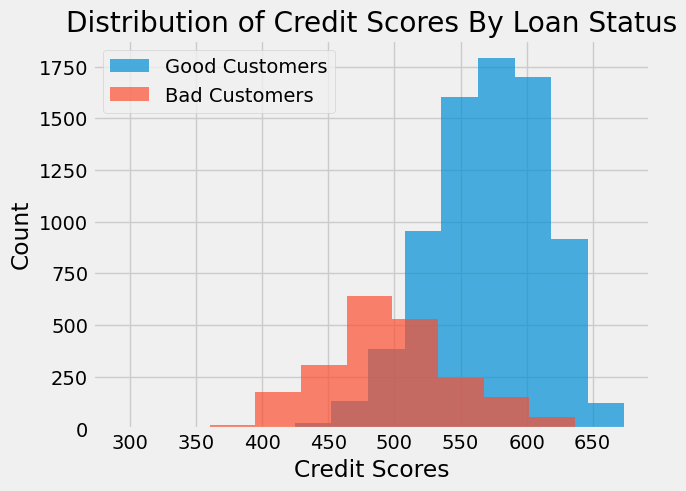

In [22]:
credit_scores_df["loan_status"] = y_test
credit_scores_df.loc[credit_scores_df["loan_status"]==0, "credit_score"].hist(alpha=0.7, label="Good Customers")
credit_scores_df.loc[credit_scores_df["loan_status"]==1, "credit_score"].hist(alpha=0.7, label="Bad Customers")
plt.title("Distribution of Credit Scores By Loan Status")
plt.xlabel("Credit Scores")
plt.ylabel("Count")
plt.legend()
plt.show()

This shows that customers has a high chance of default if their credit scores are low.

In [23]:
import pandas as pd
import numpy as np

CREDIT_LEVELS_DESCRIPTIONS = {
    1: "Very Poor",
    2: "Poor",
    3: "Below Average",
    4: "Average",
    5: "Above Average",
    6: "Good",
    7: "Very Good",
    8: "Excellent",
    9: "Exceptional",
}
LEVEL_BOUNDS = [float("-inf"), 350, 400, 450, 500, 550, 600, 650, 700, float("inf")]

def interpret_credit_score(
    df: pd.DataFrame,
    target_col: str,
) -> pd.DataFrame:
    """
    Interpret the credit score into predefined levels and descriptions.

    Args:
        df (pd.DataFrame): The dataframe containing credit score data.
        target_col (str): The column name for the credit scores in the dataframe.

    Returns:
        pd.DataFrame: The dataframe with additional columns for credit level, bounds, and descriptions.
    """
    # 1. Define conditions to categorize credit scores based on LEVEL_BOUNDS
    conditions = [
        (df[target_col] > LEVEL_BOUNDS[i]) & (df[target_col] <= LEVEL_BOUNDS[i + 1])
        for i in range(len(LEVEL_BOUNDS) - 1)
    ]

    # 2. Prepare choices for credit levels, lower bounds, and upper bounds
    level_choices = list(CREDIT_LEVELS_DESCRIPTIONS.keys())
    lower_bound_choices = LEVEL_BOUNDS[:-1]
    upper_bound_choices = LEVEL_BOUNDS[1:]

    # 3. Assign credit level, lower bound, upper bound, and description based on conditions
    df["credit_level"] = np.select(conditions, level_choices)
    df["credit_lower_bound"] = np.select(conditions, lower_bound_choices)
    df["credit_upper_bound"] = np.select(conditions, upper_bound_choices)
    df["credit_description"] = df["credit_level"].map(CREDIT_LEVELS_DESCRIPTIONS)
    return df


def generate_report(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate a report categorizing customers into credit levels and calculating the summary statistics (cumulative percentage, proportion, etc).

    Args:
        df (pd.DataFrame): The dataframe containing customer credit scores.

    Returns:
        pd.DataFrame: The report dataframe with credit levels, customer counts, and various statistics.
    """

    # 1. Categorize into credit level based on credit score:
    report_df = interpret_credit_score(df, target_col="credit_score")

    # 2. Count `Good customers` and `Bad customers` in each credit level:
    report_df = (
        report_df.groupby(
            [
                "credit_level",
                "credit_lower_bound",
                "credit_upper_bound",
                "credit_description",
            ]
        )["loan_status"]
        .value_counts()
        .unstack()
        .reset_index()
        .rename(
            columns={
                0: "Good Customers",
                1: "Bad Customers",
                "credit_level": "Credit Level",
                "credit_lower_bound": "Credit Lower Bound",
                "credit_upper_bound": "Credit Upper Bound",
                "credit_description": "Credit Description",
            }
        )
        .fillna(0)
    )
    report_df = report_df.rename_axis(None, axis=1)
    report_df["Customers"] = report_df["Good Customers"] + report_df["Bad Customers"]

    # 3. Calculate proportion of customers in each credit level
    report_df["Customers Rate"] = (
        report_df["Customers"] / report_df["Customers"].sum() * 100
    )

    # 4. Proportion of `Bad Customers` in each credit level
    report_df["Default Rate"] = (
        report_df["Bad Customers"] / report_df["Customers"] * 100
    )
    report_df["Reverse Cumulative Customers"] = report_df["Customers"][::-1].cumsum()
    report_df["Reverse Cumulative Good Customers"] = report_df["Good Customers"][
        ::-1
    ].cumsum()
    report_df["Reverse Cumulative Bad Customers"] = report_df["Bad Customers"][
        ::-1
    ].cumsum()

    # 5. Calculate the cumulative percentage of `Good Customers` from all customers
    report_df["Good Customers Coverage"] = (
        report_df["Reverse Cumulative Good Customers"]
        / report_df["Good Customers"].sum()
    )

    # 6. Calculate the cumulative percentage of `Bad Customers` from all customers
    report_df["Loss Coverage"] = (
        report_df["Reverse Cumulative Bad Customers"]
        / report_df["Reverse Cumulative Customers"]
    )

    return report_df

In [24]:
report_df = generate_report(credit_scores_df)

In [25]:
report_df.to_csv("../reports/credit_scores_report.csv", index=False)

## Explanation
This report table is a summary of credit level statistics based on the count of Good Customer and Bad Customers inside each credit level.

1. **Credit Level**: This column indicates the different levels of creditworthiness.
2. **Credit Lower** Bound and Credit Upper Bound: These columns define the score ranges for each credit level. For example, the "Very Poor" credit level ranges from negative infinity (or the lowest possible score) up to 350.
3. **Credit Description**: This column provides a description or label for each credit level.
4. **Customers**: The number of customers or individuals falling within each credit level.
5. **Customers Rate**: This column might represent the percentage of customers in each credit level relative to the total number of customers.
6. **Good Customers and Bad Customers**: The number of customers within each credit level who are classified as "Good" (low credit risk) or "Bad" (high credit risk).
7. **Default Rate**: This column indicates the percentage of customers within each credit level who have defaulted on their obligations.
8. **Good Customers Coverage**: Cumulative percentage of "Good" customers covered within each credit level start from the highest credit level.
9. **Loss Coverage**: cumulative percentage of exposed losses that we are willing to accept for a given loan, starting from a certain credit level until the highes credit level.